# Machine Learning Project - Group 7
By Trang VO

M2 Digital Economics - University Paris Dauphine

## Explanatory Analysis

- DATA

The data sets used in this notebook contain more than 20.000 French citizens with their home & job information as follows:
    - Personal info: Age (2019), educational level & gender
    - Home info: household type, home city, home department & geolocation
    - Work info: wage, company size & industry

The data sets were provided for a Machine Learning project at University Paris Dauphine. Raw data is retrieved from INSEE. 

- PROJECT GOALS:

The goal of this analysis is to:
    - Explore the global data set based on the above features
    - Select relevant indicators to characterize French departments, based on 2 groups of people: department inhabitants & workers.
    - Visualize the departments clusters using geospartial data.

- CLUSTERING ALGORITHMS:

The clustering algorithms used are KMeans and Agglomerative Clustering.

- FUTURE WORK: 

Add KModes algorithm.

### Load data & libraries

For preprocessing

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

For clustering

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward

For visualization

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('ggplot')
import geopandas as gpd
import descartes

Load data

In [5]:
folder_path = str(os.getcwd()) + '/'
city_adm = pd.read_csv(folder_path + 'city_adm.csv')
city_loc = pd.read_csv(folder_path + 'city_loc.csv')
code_activity_sector = pd.read_csv(folder_path + 'code_activity_sector.csv')
code_DEGREE = pd.read_csv(folder_path + 'code_DEGREE.csv')
code_employee_count = pd.read_csv(folder_path + 'code_employee_count.csv')
code_household_type = pd.read_csv(folder_path + 'code_household_type.csv')
departments = pd.read_csv(folder_path + 'departments.csv')
regions = pd.read_csv(folder_path + 'regions.csv')
learn = pd.read_csv(folder_path + 'learn.csv')
test = pd.read_csv(folder_path + 'test.csv')

### Data preparation

In [6]:
print(learn.shape)
learn.head(3)

(10184, 15)


,household_type,job_dep,work_condition,DEGREE,Employer_category,JOB_CATEGORY,Job_description,type_of_contract,working_hours,employee_count,INSEE_CODE,Age_2019,activity_sector,Sex,Wage
0,M_3_1,92,C,educ|1,ct_9,X,564b,AUT,1531.0,tr_2,75118,21,JC,Female,4804
1,M_4_1,59,C,educ|2,ct_7,O,563c,CDI,868.0,tr_1,59008,53,TZ,Female,10536
2,M_4_1,93,D,educ|2,ct_7,O,563a,CDI,1398.0,tr_1,93063,52,QB,Female,7119


In [7]:
print(test.shape)
test.head(3)

(10180, 14)


,household_type,job_dep,work_condition,DEGREE,Employer_category,JOB_CATEGORY,Job_description,type_of_contract,working_hours,employee_count,INSEE_CODE,Age_2019,activity_sector,Sex
0,M_4_1,95,P,educ|1,ct_2,O,523c,CDD,550.0,tr_6,78146,52,OZ,Female
1,M_4_1,59,P,educ|2,ct_9,O,676c,TTP,1142.0,tr_4,59599,29,NZ,Male
2,M_4_1,92,C,educ|2,ct_9,X,676e,AUT,798.0,tr_6,75108,27,CL,Male


Combine learn & test set for EDA

In [8]:
full_df = pd.concat([learn, test], axis=0, ignore_index=True)
print(full_df.shape)
full_df.head(3)

(20364, 15)


,household_type,job_dep,work_condition,DEGREE,Employer_category,JOB_CATEGORY,Job_description,type_of_contract,working_hours,employee_count,INSEE_CODE,Age_2019,activity_sector,Sex,Wage
0,M_3_1,92,C,educ|1,ct_9,X,564b,AUT,1531.0,tr_2,75118,21,JC,Female,4804.0
1,M_4_1,59,C,educ|2,ct_7,O,563c,CDI,868.0,tr_1,59008,53,TZ,Female,10536.0
2,M_4_1,93,D,educ|2,ct_7,O,563a,CDI,1398.0,tr_1,93063,52,QB,Female,7119.0


In [9]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20364 entries, 0 to 20363
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_type     20364 non-null  object 
 1   job_dep            20364 non-null  object 
 2   work_condition     20364 non-null  object 
 3   DEGREE             20364 non-null  object 
 4   Employer_category  20364 non-null  object 
 5   JOB_CATEGORY       20364 non-null  object 
 6   Job_description    20364 non-null  object 
 7   type_of_contract   20364 non-null  object 
 8   working_hours      20295 non-null  float64
 9   employee_count     20364 non-null  object 
 10  INSEE_CODE         20364 non-null  object 
 11  Age_2019           20364 non-null  int64  
 12  activity_sector    20364 non-null  object 
 13  Sex                20364 non-null  object 
 14  Wage               10184 non-null  float64
dtypes: float64(2), int64(1), object(12)
memory usage: 2.3+ MB


There are missing values in working_hours & Wage. This won't be a big issue as we'll use median value to summarize the data by department.

Join with city_adm table to get home department codes.

In [10]:
city_adm.columns

Index(['Nom de la commune', 'INSEE_CODE', 'TOWN_TYPE', 'Dep'], dtype='object')

In [11]:
full_df = full_df.merge(city_adm[['INSEE_CODE', 'Dep']], on='INSEE_CODE', how='left')
full_df.rename(columns={'Dep': 'home_dep'}, inplace=True)

Drop unused columns

In [12]:
full_df.columns

Index(['household_type', 'job_dep', 'work_condition', 'DEGREE',
       'Employer_category', 'JOB_CATEGORY', 'Job_description',
       'type_of_contract', 'working_hours', 'employee_count', 'INSEE_CODE',
       'Age_2019', 'activity_sector', 'Sex', 'Wage', 'home_dep'],
      dtype='object')

In [13]:
cols_to_drop = ['work_condition', 'Employer_category', 'JOB_CATEGORY',
                'Job_description', 'type_of_contract', 'INSEE_CODE']
full_df.drop(cols_to_drop, axis=1, inplace=True)
full_df.head(3)

,household_type,job_dep,DEGREE,working_hours,employee_count,Age_2019,activity_sector,Sex,Wage,home_dep
0,M_3_1,92,educ|1,1531.0,tr_2,21,JC,Female,4804.0,75
1,M_4_1,59,educ|2,868.0,tr_1,53,TZ,Female,10536.0,59
2,M_4_1,93,educ|2,1398.0,tr_1,52,QB,Female,7119.0,93


#### Household_type

In [14]:
code_household_type

,Code,Libellé
0,M_1_1,Homme vivant seul
1,M_1_2,Femme vivant seule
2,M_2_0,Plusieurs personnes sans famille
3,M_3_1,Famille principale monoparentale composée d'un...
4,M_3_2,Famille principale monoparentale composée d'un...
5,M_4_1,Famille principale composée d'un couple de deu...
6,M_4_2,Famille principale composée d'un couple où seu...
7,M_4_3,Famille principale composée d'un couple où seu...
8,M_4_4,Famille principale composée d'un couple d’aucu...


We will divide the household type into 2 big groups: single households and family households and see their distribution acrross 96 departments.

In [15]:
family_household = list(code_household_type.Code)[3:]
full_df['household_type_family'] = np.where(full_df['household_type'].isin(family_household), 1, 0)

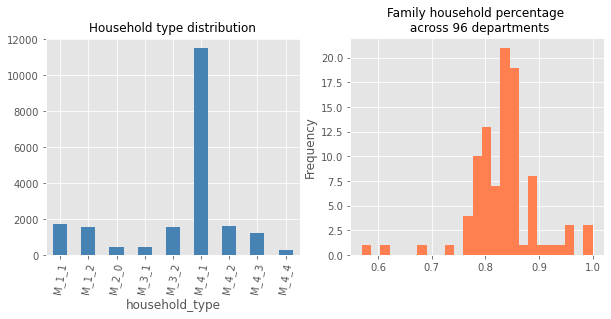

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
full_df.groupby(['household_type'])['household_type'].count().plot.bar(ax=ax[0], color='steelblue', rot=80)
full_df.groupby('home_dep')['household_type_family'].mean().round(2).plot(ax=ax[1],color='coral',
                                                                          kind='hist', bins=25)
ax[0].set_title('Household type distribution', fontsize=12)
ax[1].set_title('Family household percentage \n across 96 departments', fontsize=12)
plt.show()

- The majority of households in the data set are families.
- This is also the trend across departments, with the percentage of family household ranging from approx. 60% to 100%. The most common range is around 75-90%. This indicator can be useful to distinguish departments from each other.

#### Degree

In [17]:
code_DEGREE

,Code,Libellé
0,educ|1,Pas de scolarité ou arrêt avant la fin du prim...
1,educ|2,Aucun diplôme et scolarité interrompue à la fi...
2,educ|3,Aucun diplôme et scolarité jusqu’à la fin du c...
3,educ|1|1,CEP (certificat d’études primaires)
4,educ|1|2,"BEPC, brevet élémentaire, brevet des collèges,..."
5,educ|1|3,"CAP, BEP ou diplôme de niveau équivalent"
6,educ|1|4,"Baccalauréat général ou technologique, brevet ..."
7,educ|1|5,"Baccalauréat professionnel, brevet professionn..."
8,educ|1|6,"BTS, DUT, Deug, Deust, diplôme de la santé ou ..."
9,educ|1|7,"Licence, licence pro, maîtrise, diplôme équiva..."


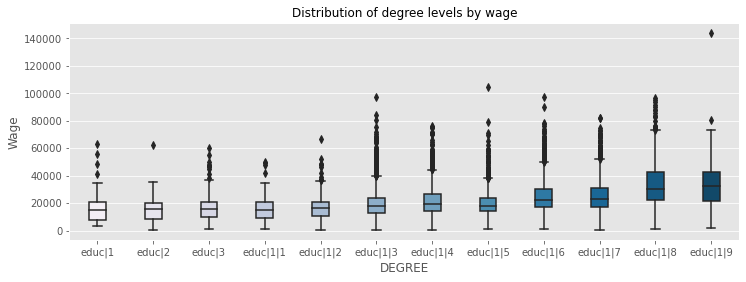

In [18]:
plt.figure(figsize=(12,4))
sns.boxplot(y='Wage', x='DEGREE',data=full_df, width=0.3, order=code_DEGREE.Code, palette="PuBu")
plt.title('Distribution of degree levels by wage', fontsize=12)
plt.show()

The graph shows a trend of people having higher degrees also get paid higher. We'll regroup this attribute into 2 levels: post-bac & others and look at the rate of people with high education degrees amongst departments.

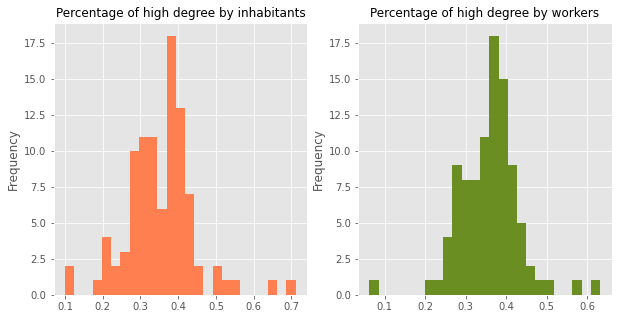

In [19]:
post_bac = list(code_DEGREE.Code)[-4:]
full_df['degree_postbac'] = np.where(full_df['DEGREE'].isin(post_bac), 1, 0)

fig2, ax2 = plt.subplots(1,2, figsize=(10,5))
full_df.groupby(['home_dep'])['degree_postbac'].mean().plot(ax=ax2[0],color='coral', kind='hist', bins=25)
full_df.groupby(['job_dep'])['degree_postbac'].mean().plot(ax=ax2[1],color='olivedrab', kind='hist', bins=25)
ax2[0].set_title('Percentage of high degree by inhabitants', fontsize=12)
ax2[1].set_title('Percentage of high degree by workers', fontsize=12)
plt.show()

The graphs above characterize departments by their inhabitants and the people who work there in terms of high education degree:
- In most of departments, these indicators range from 25% to 45%.
- In a very few departments, the skillful employees are highly concerntrated at more than 50%.

#### Employee count (company size)

In [20]:
code_employee_count

,Code,Libellé
0,tr_0,"0 poste (salariés présents en cours d'année, m..."
1,tr_1,[1;10[ postes
2,tr_2,[10;20[ postes
3,tr_3,[20;50[ postes
4,tr_4,[50;100[ postes
5,tr_5,[100;250[ postes
6,tr_6,[250;+[ postes


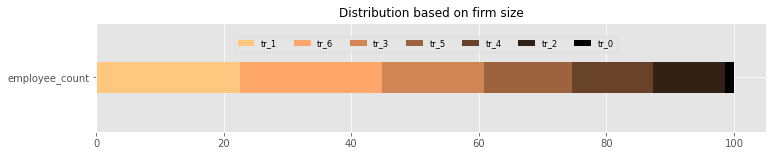

In [21]:
employee_count_pct = full_df['employee_count'].value_counts(normalize=True)*100

employee_count_pct.to_frame().T.plot.barh(stacked=True, figsize=(12,2), width=0.2, colormap='copper_r')
plt.title('Distribution based on firm size', fontsize=12)
plt.legend(ncol=7, bbox_to_anchor=(0.2, 0.7), loc='lower left', fontsize='small')
plt.show()

To make this feature comparable amongst departments, we'll regroup the enterprises into 2 categories: large companies (250+ employees) and others.

In [22]:
full_df['employee_count_big_company'] = (full_df['employee_count'] == 'tr_6').astype(int)
full_df['employee_count_big_company'].value_counts()

0    15828
1     4536
Name: employee_count_big_company, dtype: int64

#### Activity sector

In [23]:
print(code_activity_sector.shape)
code_activity_sector.head()

(38, 2)


,Code,Libellé
0,AZ,"Agriculture, sylviculture et pêche"
1,BZ,Industries extractives
2,CA,"Fabrication de denrées alimentaires, de boisso..."
3,CB,"Fabrication de textiles, industries de l'habil..."
4,CC,"Travail du bois, industries du papier et impri..."


In [24]:
full_df['activity_sector'].unique().shape[0]

37

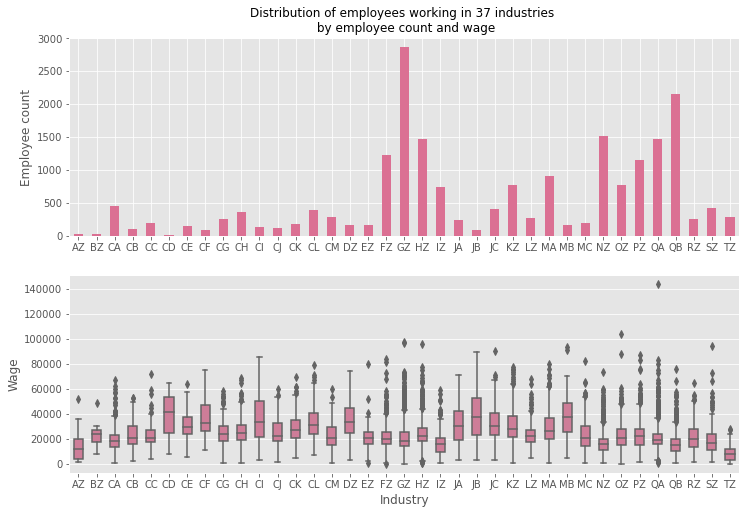

In [25]:
fig3, ax3 = plt.subplots(2,1, figsize=(12,8))
full_df.groupby(['activity_sector'])['activity_sector'].count().plot.bar(ax=ax3[0],
                                                                         color='palevioletred', rot=0)
ax3[0].set_title('Distribution of employees working in 37 industries \n by employee count and wage', fontsize=12)
ax3[0].set_xlabel(None)
ax3[0].set_ylabel('Employee count')

sns.boxplot(ax=ax3[1],data=full_df, x='activity_sector',y='Wage', width=0.5,
            color='palevioletred', order=code_activity_sector.Code[:-1])
ax3[1].set_xlabel('Industry')
ax3[1].set_ylabel('Wage')
plt.show()

- In the data set, a majority of employees work in medium-low paying industries, while the highly paid workers are underpresented.
- Nevertheless, we'll separate the workers into 2 groups based on the industry they work in: large industries (see below) and others. By this, we can explore whether the concerntration of highly paid workers differ amongst departments.

Large industry category:
- CD Coking and refining
- CE Chemical industry
- CF Pharmaceutical
- CI Manufacture of computer, electronic and electrical products
- CJ Manufacture of electrical equipment
- CK Manufacture of machinery and equipment n.e.c.
- CL Manufacture of transport equipment 
- DZ Electricity generation and distribution, distribution of electricity, gas and water, ...
- JA Publishing & audiovisual
- JB Telecomunication
- JC IT service
- KZ Financial and insurance activities
- MA Legal, accounting & management activities
- MB Scientific research

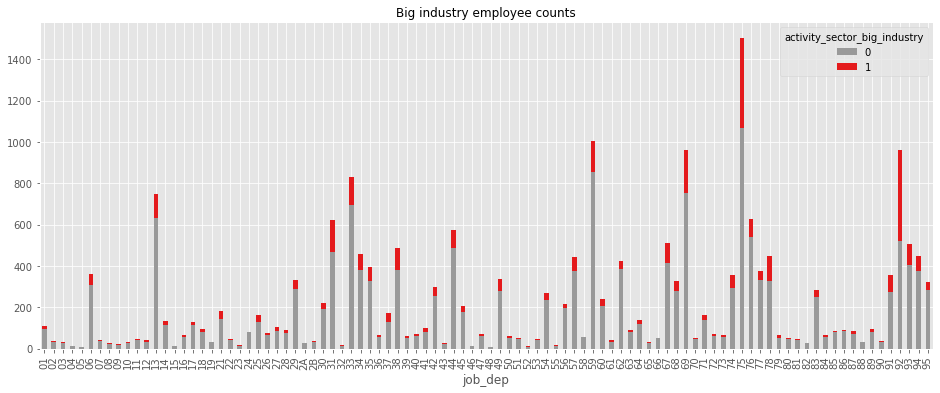

In [26]:
large_industry = ['CD', 'CE', 'CF', 'CI', 'CJ', 'CK', 'CL', 'DZ', 'JA', 'JB', 'JC', 'KZ', 'MA', 'MB']
full_df['activity_sector_big_industry'] = np.where(full_df['activity_sector'].isin(large_industry), 1, 0)

fig4, ax4 = plt.subplots(figsize=(16,6))
pd.crosstab(full_df['job_dep'], full_df['activity_sector_big_industry']).\
            plot.bar(ax= ax4, stacked=True, cmap='Set1_r')
plt.title('Big industry employee counts', fontsize=12)
plt.show()

- Large industry employees are concerntrated in highly populated departments, such as department 75, 92, 69 and 31, and vice versa. This can be an useful feature in department clustering.

#### Gender

In [27]:
full_df['Sex'].value_counts()

Female    10278
Male      10086
Name: Sex, dtype: int64

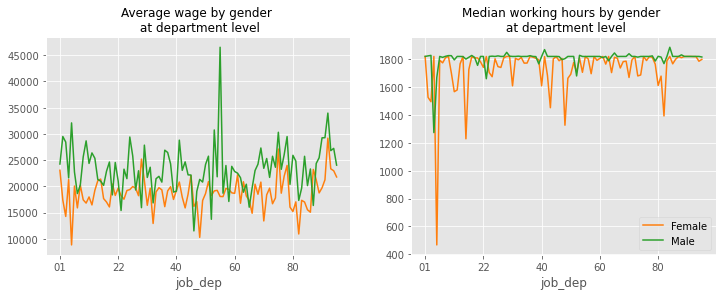

In [28]:
fig5, ax5 = plt.subplots(1,2,figsize=(12,4))

full_df[full_df['Sex']=='Female'].groupby(['job_dep'])['Wage'].mean().plot(ax=ax5[0], c='tab:orange')
full_df[full_df['Sex']=='Male'].groupby(['job_dep'])['Wage'].mean().plot(ax=ax5[0], c='tab:green')
ax5[0].set_title('Average wage by gender \n at department level',fontsize=12)

full_df[full_df['Sex']=='Female'].groupby(['job_dep'])['working_hours'].median().plot(ax=ax5[1], c='tab:orange')
full_df[full_df['Sex']=='Male'].groupby(['job_dep'])['working_hours'].median().plot(ax=ax5[1], c='tab:green')
ax5[1].set_title('Median working hours by gender \n at department level',fontsize=12)

plt.legend(('Female', 'Male'))
plt.show()

From department level:
- Apart from very few exceptions, there is a significant difference in average salary between 2 genders, in both low and high salary ranges.
- In most of the departments, men work longer hours than women. This may partly explain the gender pay gap.

For convenience, we'll transform gender indicator into a binary variable.

In [29]:
full_df['gender_female'] = (full_df['Sex'] == 'Female').astype(int)

Drop the original columns.

In [30]:
full_df.columns

Index(['household_type', 'job_dep', 'DEGREE', 'working_hours',
       'employee_count', 'Age_2019', 'activity_sector', 'Sex', 'Wage',
       'home_dep', 'household_type_family', 'degree_postbac',
       'employee_count_big_company', 'activity_sector_big_industry',
       'gender_female'],
      dtype='object')

In [31]:
full_df.drop(columns=['household_type', 'DEGREE', 'employee_count', 'activity_sector', 'Sex'], inplace=True)
full_df.head(3)

,job_dep,working_hours,Age_2019,Wage,home_dep,household_type_family,degree_postbac,employee_count_big_company,activity_sector_big_industry,gender_female
0,92,1531.0,21,4804.0,75,1,0,0,1,1
1,59,868.0,53,10536.0,59,1,0,0,0,1
2,93,1398.0,52,7119.0,93,1,0,0,0,1


#### Age & working hours

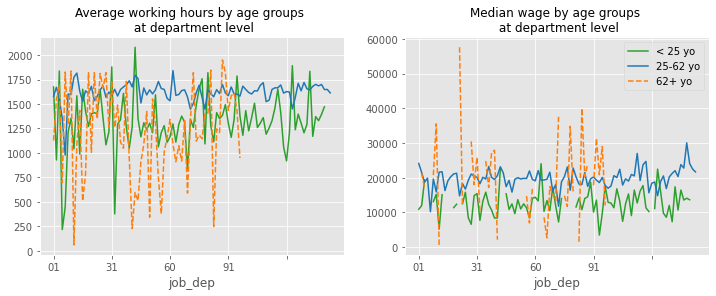

In [32]:
fig6, ax6 = plt.subplots(1,2, figsize=(12,4))
full_df[full_df['Age_2019']<=25].groupby(['job_dep'])['working_hours'].mean().plot(ax=ax6[0], c='tab:green')
full_df[(full_df['Age_2019']>25) & (full_df['Age_2019']<=62)].groupby(['job_dep'])['working_hours']\
                                                    .mean().plot(ax=ax6[0], c='tab:blue')
full_df[full_df['Age_2019']>62].groupby(['job_dep'])['working_hours']\
                                                    .mean().plot(ax=ax6[0], c='tab:orange', linestyle='dashed')
ax6[0].set_title('Average working hours by age groups \n at department level',fontsize=12)

full_df[full_df['Age_2019']<=25].groupby(['job_dep'])['Wage'].median().plot(ax=ax6[1], c='tab:green')
full_df[(full_df['Age_2019']>25) & (full_df['Age_2019']<=62)].groupby(['job_dep'])['Wage']\
                                                    .median().plot(ax=ax6[1], c='tab:blue')
full_df[full_df['Age_2019']>62].groupby(['job_dep'])['Wage']\
                                                    .median().plot(ax=ax6[1], c='tab:orange', linestyle='dashed')
ax6[1].set_title('Median wage by age groups \n at department level',fontsize=12)

plt.legend(('< 25 yo', '25-62 yo', '62+ yo'))
plt.show()

Plotting the average working hours and median wage for each age group shows that:
- There is a large pay gap between the youngest age group of below 25 and the group from 25 to 62, corresponding to the difference in the average working hours. The young labor group works less hours on average, and recieves lower salary. This might associate with the fact that many young people start working with a temporary contract or at a job that requires less experience.
- After the retirement age, the senior group working hours drop substantially, leading to the large fluctuation in their salary.

### Department data sets

#### Home departments

To characterize home departments by their inhabitants, we'll look at the following indicators:
- Number of inhabitants
- Average age (2019)
- High education degree (post-bac or not)
- Family household type (family or single household)
- Gender demographics.

In [33]:
home_dict = {'Wage': 'median',
            'Age_2019': 'mean',
            'gender_female': 'mean', 
            'household_type_family': 'mean',
            'degree_postbac': 'mean',
            'job_dep': 'count'} # count inhabitants, renamed afterwards

In [34]:
home_departments = full_df.groupby(['home_dep']).agg(home_dict).reset_index()
home_departments.rename(columns={'Wage': 'median_wage',
                                'Age_2019': 'average_age_2019',
                                'gender_female': 'gender_female_pct',
                                'household_type_family': 'household_type_family_pct',
                                 'degree_postbac': 'degree_postbac_pct',
                                'job_dep': 'number_of_inhabitants'}, inplace=True)
home_departments.head(3)

,home_dep,median_wage,average_age_2019,gender_female_pct,household_type_family_pct,degree_postbac_pct,number_of_inhabitants
0,01,21920.0,42.267442,0.593023,0.802326,0.337209,86
1,02,17097.0,41.884615,0.538462,0.692308,0.307692,26
2,03,20349.5,41.538462,0.538462,0.884615,0.384615,26


In [35]:
home_departments.describe()

,median_wage,average_age_2019,gender_female_pct,household_type_family_pct,degree_postbac_pct,number_of_inhabitants
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,19323.598958,42.552024,0.509145,0.834014,0.355240,212.125000
std,2620.979506,2.041816,0.069684,0.062842,0.092383,241.607261
min,9540.500000,34.600000,0.142857,0.571429,0.100000,5.000000
25%,18243.500000,41.622733,0.485082,0.802087,0.300434,34.750000
50%,19242.000000,42.247227,0.510640,0.833585,0.358937,85.000000
75%,20459.750000,43.404561,0.538462,0.857143,0.403853,347.750000
max,27809.000000,49.285714,0.700000,1.000000,0.711670,956.000000


In [36]:

# plt.figure(figsize=(6,4))
# sns.lineplot(data=home_departments[[ 'household_type_family_pct', 'gender_female_pct','degree_postbac_pct']],
#              palette='tab10', linewidth=2.5)
# plt.legend(bbox_to_anchor=(1, 0.4), loc='lower left', fontsize='small')
# plt.title('Rate of family household, high education degree \n & female demographics', fontsize=12)
# plt.show()

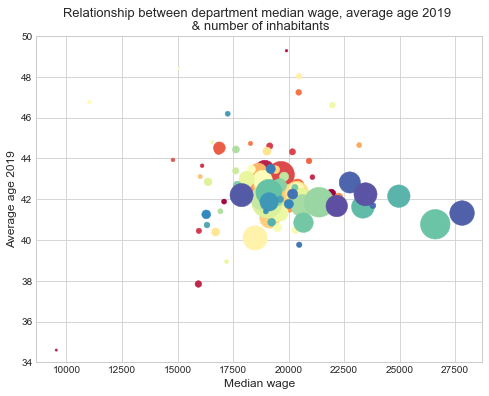

In [37]:
style.use('seaborn-whitegrid')
colors = np.arange(1,97,1)
fig,ax7 = plt.subplots(figsize=(8,6))
ax7.scatter(data=home_departments, x='median_wage', y='average_age_2019',
           s='number_of_inhabitants', c=colors, cmap='Spectral') 
plt.ylim(34,50)
plt.xlabel('Median wage')
plt.ylabel('Average age 2019')
plt.title('Relationship between department median wage, average age 2019 \n & number of inhabitants', fontsize=13)
plt.show()

Observation: 
- In terms of number of inhabitants, there is a significant distinction between highly concentrated regions & the rest of the country.
- In terms of age, the departments with highest number of inhabitants also have reasonable younger average age from 40 to 44 years old. All the departments with average age above 44 have very low number of inhabitants.
- In terms of wage, there are a number of low populated departments with lowest median wage of less than 17500 euros per year. Meanwhile, the highly populated departments have the median wage all above 17500 euros,with 3 departments having the highest median wage of more than 25000 euros/person/year.

#### Job deparments

To characterize job departments by their workers, we'll look at the number of workers, their average age, high education level, characteristic of the firm and the industry they work in.

In [38]:
job_dict = {'Wage': 'median',
           'working_hours': 'mean',
            'Age_2019': 'mean',
            'gender_female': 'size',
            'degree_postbac': 'mean',
            'employee_count_big_company': 'mean',
            'activity_sector_big_industry': 'mean'}

In [39]:
job_departments = full_df.groupby(['job_dep']).agg(job_dict).reset_index()
job_departments.rename(columns={'Wage': 'median_wage',
                                'working_hours': 'average_working_hours',
                                'Age_2019': 'average_age_2019',
                                'gender_female': 'number_of_workers',
                                'degree_postbac': 'degree_postbac_pct',
                                'employee_count_big_company': 'work_at_big_company_pct',
                                'activity_sector_big_industry': 'work_in_big_industry_pct'}, inplace=True)
job_departments.head(3)

,job_dep,median_wage,average_working_hours,average_age_2019,number_of_workers,degree_postbac_pct,work_at_big_company_pct,work_in_big_industry_pct
0,01,21984.5,1588.560748,40.672897,107,0.336449,0.149533,0.130841
1,02,20619.0,1610.459459,42.054054,37,0.297297,0.243243,0.135135
2,03,18732.0,1576.354839,41.032258,31,0.354839,0.193548,0.096774


In [40]:
job_departments.describe()

,median_wage,average_working_hours,average_age_2019,number_of_workers,degree_postbac_pct,work_at_big_company_pct,work_in_big_industry_pct
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,19226.843750,1588.768863,42.362165,212.125000,0.358842,0.167415,0.147120
std,2546.296122,103.413324,1.525038,267.522011,0.073366,0.079541,0.068726
min,10227.000000,901.571429,37.656250,7.000000,0.062500,0.000000,0.000000
25%,17797.250000,1559.311451,41.494128,41.000000,0.313839,0.116924,0.112249
50%,19356.500000,1594.953695,42.328846,87.500000,0.363058,0.171799,0.141454
75%,20316.000000,1637.799345,43.288462,327.000000,0.393870,0.221484,0.170221
max,28506.000000,1799.517241,46.428571,1503.000000,0.631250,0.417708,0.459375


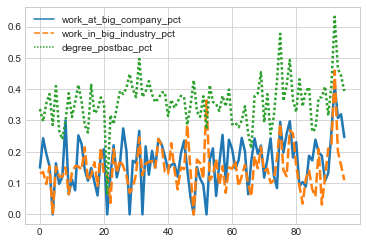

In [41]:
plt.figure(figsize=(6,4))
sns.lineplot(data=job_departments[['work_at_big_company_pct', 'work_in_big_industry_pct', 'degree_postbac_pct']],
             palette='tab10', linewidth=2.5)
plt.show()

- There're departments with high concentration of employees who have high education degrees, work in big industries & large companies.
- On the contrary, there are also a number of departments with very low rate of people working in big industries & big companies, although this doesn't always correspond to the rate of workers having high degrees.

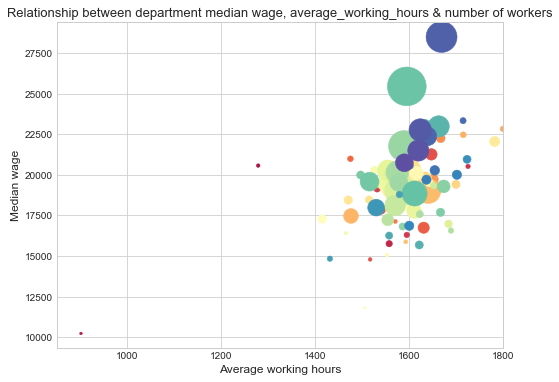

In [42]:
colors = np.arange(1,97,1)
fig,ax8 = plt.subplots(figsize=(8,6))
ax8.scatter(data=job_departments, x='average_working_hours', y='median_wage',
           s='number_of_workers', c=colors, cmap='Spectral') 
plt.xlim(850,1800)
plt.xlabel('Average working hours')
plt.ylabel('Median wage')
plt.title('Relationship between department median wage, average_working_hours & number of workers', fontsize=13)
plt.show()

### Clustering

#### Home departments

Scale all features:

In [43]:
scaler = StandardScaler()
home_departments_s = scaler.fit_transform(home_departments.drop(['home_dep', 'median_wage'],
                                                              axis=1))

##### K-Means

In [44]:
k_range_home = np.arange(2, 11, 1)
kmeans_inertia_home = []
s_core_home = []
for k in k_range_home:
    kmeans_algo =KMeans(n_clusters=k, random_state=1)
    kmeans_algo.fit(home_departments_s)
    kmeans_inertia_home.append(kmeans_algo.inertia_ / k)
    s_core_home.append(silhouette_score(home_departments_s, kmeans_algo.labels_))

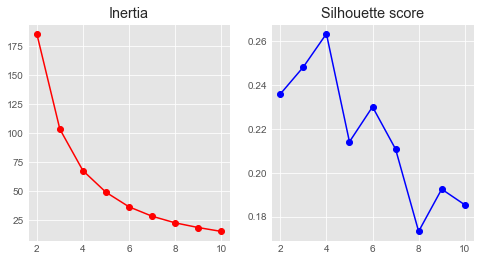

In [45]:
style.use('ggplot')
fig, ax9 = plt.subplots(1,2, figsize=(8,4))
ax9[0].plot(k_range_home, kmeans_inertia_home, linestyle='-', marker='o', color='r')
ax9[1].plot(k_range_home, s_core_home, linestyle='-', marker='o', color='b')
ax9[0].set_title('Inertia')
ax9[1].set_title('Silhouette score')
# plt.figure(figsize=(4,6))
plt.show()

Looking at the inertia scores, the optimal number of k can be 4 or 5. The silhouette scores are very low, meaning the clusters are not well separated. We'll choose the optimal numbers of cluster at 5, where the inertia score is reduced significantly and the silhouette score is the second highest.

In [46]:
kmeans_home_4 = KMeans(n_clusters=4, random_state=9)
kmeans_home_4.fit(home_departments_s)

KMeans(n_clusters=4, random_state=9)

In [47]:
home_departments['home_cluster_kmeans_4'] = kmeans_home_4.labels_
home_departments['home_cluster_kmeans_4'].value_counts()

2    49
1    23
0    18
3     6
Name: home_cluster_kmeans_4, dtype: int64

##### Hierarchical clustering

In [48]:
# apply the ward clustering
distance_array_home = ward(home_departments_s)

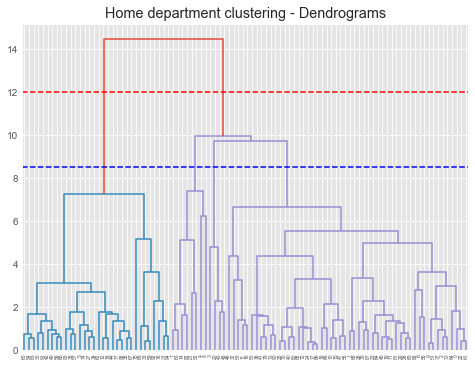

In [49]:
# plot the dendrogram
plt.figure(figsize=(8,6))
dendrogram(distance_array_home)
plt.axhline(y=12, color='r', linestyle='--')
plt.axhline(y=8.5, color='b', linestyle='--')
plt.title('Home department clustering - Dendrograms')
plt.show()

According to the Agglomerative Clustering Algorithm, the optimal numbers of clusters is 2, following by 4. We'll choose 4 clusters to see the compatible results with KMeans.

In [50]:
agg_clustering_home = AgglomerativeClustering(n_clusters=4)

In [51]:
home_departments['home_cluster_agglo_4'] = agg_clustering_home.fit_predict(home_departments_s)

##### Results

List of departments in each clusters:

In [52]:
print('List of home departments in 4 clusters by KMeans:')
dict(home_departments.groupby(['home_cluster_kmeans_4'])['home_dep'].unique())

List of home departments in 4 clusters by KMeans:


{0: array(['08', '11', '12', '15', '16', '17', '19', '23', '24', '32', '46',
        '52', '53', '61', '63', '66', '72', '88'], dtype=object),
 1: array(['06', '13', '29', '31', '33', '34', '35', '38', '44', '57', '59',
        '67', '69', '74', '75', '76', '77', '78', '91', '92', '93', '94',
        '95'], dtype=object),
 2: array(['01', '02', '03', '05', '07', '10', '14', '18', '21', '25', '26',
        '27', '28', '2A', '2B', '30', '36', '37', '39', '40', '41', '42',
        '45', '47', '49', '50', '51', '54', '55', '56', '58', '60', '62',
        '64', '65', '68', '70', '71', '73', '79', '80', '81', '83', '84',
        '85', '86', '87', '89', '90'], dtype=object),
 3: array(['04', '09', '22', '43', '48', '82'], dtype=object)}

In [53]:
print('List of home departments in 4 clusters by Agglomerative Clustering ():')
dict(home_departments.groupby(['home_cluster_agglo_4'])['home_dep'].unique())

List of home departments in 4 clusters by Agglomerative Clustering ():


{0: array(['05', '08', '09', '15', '23', '52', '63', '82'], dtype=object),
 1: array(['06', '13', '29', '30', '31', '33', '34', '35', '38', '42', '44',
        '49', '54', '56', '57', '59', '60', '62', '67', '68', '69', '74',
        '75', '76', '77', '78', '83', '91', '92', '93', '94', '95'],
       dtype=object),
 2: array(['01', '02', '03', '07', '10', '11', '12', '14', '16', '17', '18',
        '19', '21', '24', '25', '26', '27', '28', '2A', '2B', '32', '36',
        '37', '39', '40', '41', '45', '46', '47', '50', '51', '53', '55',
        '58', '61', '64', '65', '66', '70', '71', '72', '73', '79', '80',
        '81', '84', '85', '86', '87', '88', '89', '90'], dtype=object),
 3: array(['04', '22', '43', '48'], dtype=object)}

Visualize the clusters

In [54]:
# using PCA to reduce the data dimension to 2D
pca_home = PCA(n_components=2)
home_dep_pca = pca_home.fit_transform(home_departments_s)
print('% of variance preserved after transformation:\n{}'.\
      format(np.cumsum(pca_home.explained_variance_ratio_)))

% of variance preserved after transformation:
[0.37360665 0.59149086]


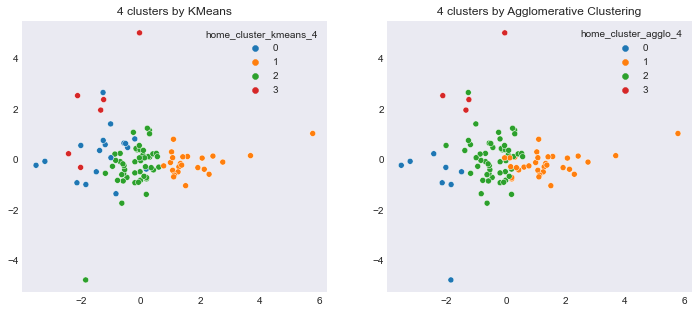

In [55]:
style.use('seaborn-dark')
fig, ax10 = plt.subplots(1,2, figsize=(12,5))
sns.scatterplot(ax=ax10[0], x=home_dep_pca[:,0], y=home_dep_pca[:,1],
                                            hue=home_departments['home_cluster_kmeans_4'], palette='tab10')
ax10[0].set_title('4 clusters by KMeans', fontsize=12)

sns.scatterplot(ax=ax10[1], x=home_dep_pca[:,0], y=home_dep_pca[:,1],
                                            hue=home_departments['home_cluster_agglo_4'], palette='tab10')
ax10[1].set_title('4 clusters by Agglomerative Clustering', fontsize=12)
plt.show()

The clusters by Agglomerative Clustering seem to be better separated. So we'll use its results to investigate the department characteristics in each cluster:

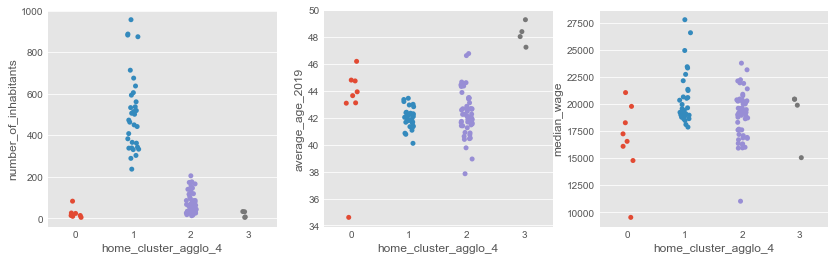

In [56]:
style.use('ggplot')
fig11, ax11 = plt.subplots(1,3, figsize=(14,4))
for i, column in zip([0,1,2], ['number_of_inhabitants', 'average_age_2019', 'median_wage']):
    sns.stripplot(ax=ax11[i], data=home_departments, x='home_cluster_agglo_4', y=column)
plt.show()

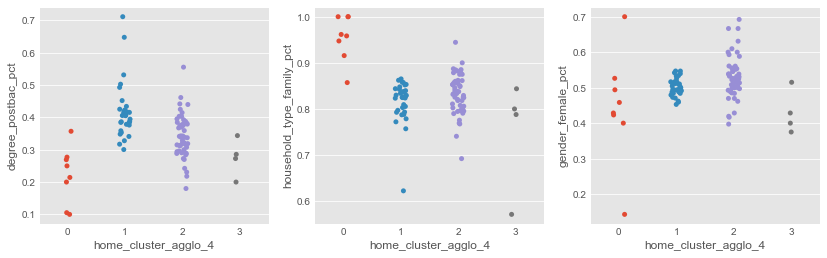

In [57]:
fig12, ax12 = plt.subplots(1,3, figsize=(14,4))
for i, column in zip([0,1,2], ['degree_postbac_pct', 'household_type_family_pct', 'gender_female_pct']):
    sns.stripplot(ax=ax12[i], data=home_departments, x='home_cluster_agglo_4', y=column)
plt.show()

Observations:
- Cluster 1 includs departments with highest representation of inhabitants in the data set, corresponding to more highly populated departments and regions in France. Their inhabitants have average age concentrating in range from 40 to 44 years old. In terms of education background, 30-70% department citizens in the data set have obtained postbac degree percentage and have median wage above 17.5000 euros.
- Cluster_0, cluster 2 and cluster 3 all have very low citizen representation in the data set, which probably correspond to the low populated regions.
- Cluster 0 and 3 both have people with higher average age, lower rate of people with high education degree. Regarding the household type, cluster 0 contains departments with highest rates of family households.

#### Job departments

Scale all features:

In [58]:
scaler = StandardScaler()
job_departments_s = scaler.fit_transform(job_departments.drop(['job_dep', 'median_wage'], axis=1))

##### K-Means

In [59]:
k_range_job = np.arange(2, 11, 1)
kmeans_inertia_job = []
s_core_job = []
for k in k_range_job:
    kmeans_algo =KMeans(n_clusters=k, random_state=1)
    kmeans_algo.fit(job_departments_s)
    kmeans_inertia_job.append(kmeans_algo.inertia_ / k)
    s_core_job.append(silhouette_score(job_departments_s, kmeans_algo.labels_))

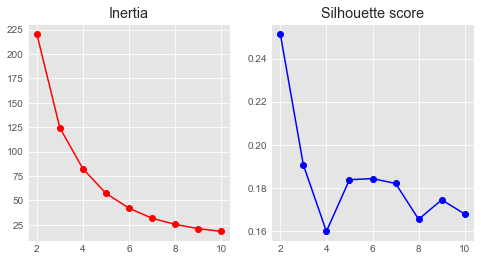

In [60]:
style.use('ggplot')
fig13, ax13 = plt.subplots(1,2, figsize=(8,4))
ax13[0].plot(k_range_job, kmeans_inertia_job, linestyle='-', marker='o', color='r')
ax13[1].plot(k_range_job, s_core_job, linestyle='-', marker='o', color='b')
ax13[0].set_title('Inertia')
ax13[1].set_title('Silhouette score')
# plt.figure(figsize=(4,6))
plt.show()

Looking at the inertia scores, there's no clear "elbow" point. The silhouette scores are also very low, meaning the clusters are not clear-cut. We'll choose the optimal numbers of cluster at 3, where the inertia score is reduced significantly and the silhouette score doesn't drop too much.

In [61]:
kmeans_job_3 =KMeans(n_clusters=3, random_state=9)
kmeans_job_3.fit(job_departments_s)

KMeans(n_clusters=3, random_state=9)

In [62]:
job_departments['job_cluster_kmeans_3'] = kmeans_job_3.labels_
job_departments['job_cluster_kmeans_3'].value_counts()

0    55
1    28
2    13
Name: job_cluster_kmeans_3, dtype: int64

##### Hierarchical clustering

In [63]:
# apply the ward clustering
distance_array_job = ward(job_departments_s)

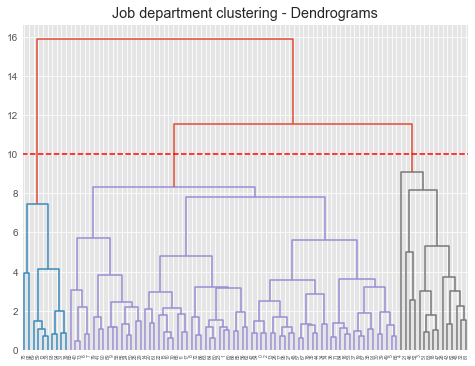

In [64]:
# plot the dendrogram
plt.figure(figsize=(8,6))
dendrogram(distance_array_job)
plt.axhline(y=10, color='r', linestyle='--')
plt.title('Job department clustering - Dendrograms')
plt.show()

The clear distance to cut is at 2 or 3 clusters. As cutting to 2 clusters creates 2 very imbalanced clusters, we'll choose cutting to 3 clusters and see if they are well separated.

In [65]:
agg_clustering_job = AgglomerativeClustering(n_clusters=3)

In [66]:
job_departments['job_cluster_agglo_3'] = agg_clustering_job.fit_predict(job_departments_s)

##### Results

In [67]:
print('List of job departments in 3 clusters by KMeans:')
dict(job_departments.groupby(['job_cluster_kmeans_3'])['job_dep'].unique())

List of job departments in 3 clusters by KMeans:


{0: array(['01', '02', '03', '06', '07', '08', '09', '14', '18', '21', '25',
        '26', '27', '28', '29', '2B', '34', '35', '36', '37', '40', '41',
        '42', '44', '45', '49', '50', '53', '54', '55', '56', '57', '58',
        '60', '62', '63', '64', '66', '68', '71', '72', '73', '74', '76',
        '77', '79', '80', '84', '85', '86', '87', '88', '89', '90', '95'],
       dtype=object),
 1: array(['04', '05', '10', '11', '12', '15', '16', '17', '19', '22', '23',
        '24', '2A', '30', '32', '39', '43', '46', '47', '48', '51', '52',
        '61', '65', '70', '81', '82', '83'], dtype=object),
 2: array(['13', '31', '33', '38', '59', '67', '69', '75', '78', '91', '92',
        '93', '94'], dtype=object)}

In [68]:
print('List of job departments in 3 clusters by Agglomerative Clustering:')
dict(job_departments.groupby(['job_cluster_agglo_3'])['job_dep'].unique())

List of job departments in 3 clusters by Agglomerative Clustering:


{0: array(['04', '05', '19', '23', '2A', '32', '43', '46', '47', '48', '51',
        '52', '81', '82', '83'], dtype=object),
 1: array(['13', '31', '33', '59', '69', '75', '78', '92', '93', '94'],
       dtype=object),
 2: array(['01', '02', '03', '06', '07', '08', '09', '10', '11', '12', '14',
        '15', '16', '17', '18', '21', '22', '24', '25', '26', '27', '28',
        '29', '2B', '30', '34', '35', '36', '37', '38', '39', '40', '41',
        '42', '44', '45', '49', '50', '53', '54', '55', '56', '57', '58',
        '60', '61', '62', '63', '64', '65', '66', '67', '68', '70', '71',
        '72', '73', '74', '76', '77', '79', '80', '84', '85', '86', '87',
        '88', '89', '90', '91', '95'], dtype=object)}

Visualize the clusters

In [69]:
# reduce dimensions to 2D
pca = PCA(n_components=2)
job_dep_pca = pca.fit_transform(job_departments_s)
print('% of variance preserved after transformation:\n{}'.\
      format(np.cumsum(pca.explained_variance_ratio_)))

% of variance preserved after transformation:
[0.42573035 0.60193731]


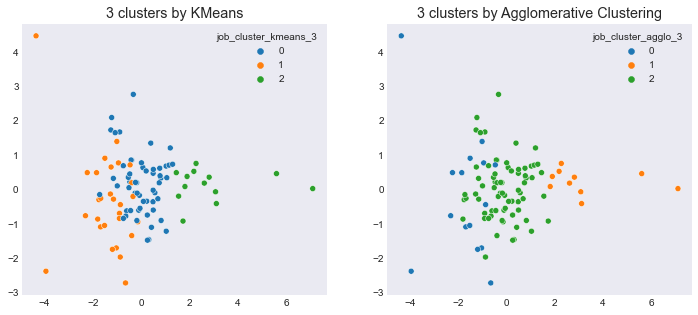

In [70]:
style.use('seaborn-dark')
fig, ax14 = plt.subplots(1,2, figsize=(12,5))
sns.scatterplot(ax=ax14[0], x=job_dep_pca[:,0], y=job_dep_pca[:,1],
                                            hue=job_departments['job_cluster_kmeans_3'], palette='tab10')
ax14[0].set_title('3 clusters by KMeans')

sns.scatterplot(ax=ax14[1], x=job_dep_pca[:,0], y=job_dep_pca[:,1],
                                            hue=job_departments['job_cluster_agglo_3'], palette='tab10')
ax14[1].set_title('3 clusters by Agglomerative Clustering')
plt.show()

We use the clusters by KMeans to see the department characteristics in each cluster:

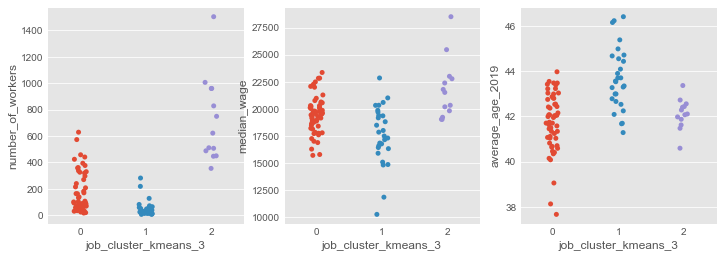

In [71]:
style.use('ggplot')
fig15, ax15 = plt.subplots(1,3, figsize=(12,4))
for i, column in zip([0,1,2], ['number_of_workers', 'median_wage', 'average_age_2019']):
    sns.stripplot(ax=ax15[i], data=job_departments, x='job_cluster_kmeans_3', y=column)
plt.show()

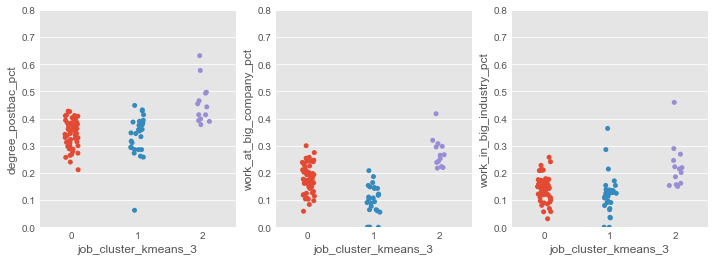

In [72]:
fig16, ax16 = plt.subplots(1,3, figsize=(12,4))
for i, column in zip([0,1,2], ['degree_postbac_pct', 'work_at_big_company_pct', 'work_in_big_industry_pct']):
    sns.stripplot(ax=ax16[i], data=job_departments, x='job_cluster_kmeans_3', y=column).set(ylim=(0,0.8))
plt.show()

Job department clusters' characteristics:
- Cluster 2: consisting of major cities & regions: higher representation in the data set, which corresponds to these populated departments. These departments also have significantly higher rate of people with high education degree, work at a large company and have higher range of salary.

- Cluster 0 & 1 all have low representation in the data set, probably corresponding to the less populated regions. These departments also have low rate of people having high degrees, working in big industries and large companies. However, there's no significant distinction between cluster 0 & 1.

#### Compare home & job department clusters

In [73]:
# load geospartial data about department boundaries
dep_boundaries = gpd.read_file(folder_path + 'departements.geojson')
dep_boundaries.columns

Index(['code', 'nom', 'geometry'], dtype='object')

In [74]:
# prepare to join dep data sets
dep_boundaries['home_dep'] = dep_boundaries['code']
dep_boundaries.rename(columns={'code': 'job_dep'}, inplace=True)
dep_boundaries.columns

Index(['job_dep', 'nom', 'geometry', 'home_dep'], dtype='object')

In [75]:
job_departments = dep_boundaries.merge(job_departments, on='job_dep', how='left')
home_departments = dep_boundaries[['home_dep', 'nom', 'geometry']].merge(home_departments,
                                                                        on='home_dep', how='left')

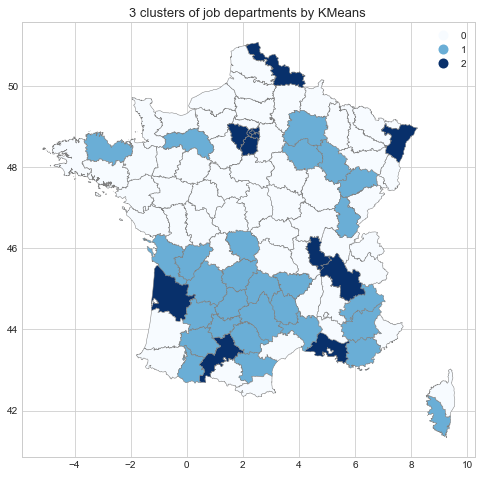

In [76]:
# plot the cluster labels onto the France map
style.use('seaborn-whitegrid')
job_departments.plot(figsize=(10,8), column=job_departments['job_cluster_kmeans_3'], categorical=True,
                      edgecolor='grey', zorder=10,
                      cmap=sns.color_palette('Blues', as_cmap=True), legend=True)
plt.title('3 clusters of job departments by KMeans ', fontsize=13)
plt.show()

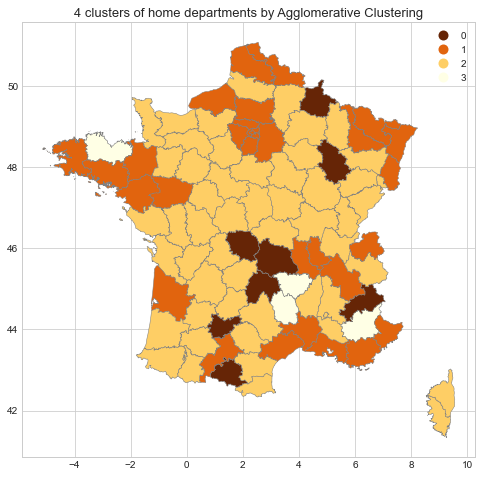

In [77]:
home_departments.plot(figsize=(10,8), column=home_departments['home_cluster_agglo_4'], categorical=True,
                      edgecolor='grey', zorder=10,
                      cmap=sns.color_palette('YlOrBr_r', as_cmap=True), legend=True)
plt.title('4 clusters of home departments by Agglomerative Clustering', fontsize=13)
plt.show()